In [14]:
import numpy as np
import pandas as pd
import glob
import unicodedata
import string
import os
import time
from io import open
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [2]:
def unicode_to_ascii(s):
    """Unicode string to plain ASCII.
    
    """
    decoded = "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )
    return decoded


def read_lines(filename):
    """Read a file and split into lines.
    
    """
    lines = open(filename, encoding="utf-8").read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


def letter_to_index(letter):
    """Find letter index from all_letters.
    
    """
    return all_letters.find(letter)


def category_to_tensor(category):
    """Get 1-hot encoding for a category 
    
    """
    cat_i = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][cat_i] = 1
    return tensor


def input_to_tensor(line):
    """Get 1-hot (line length, 1, n_letters) of first to last letters (not including EOS) for input.
    
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def target_to_tensor(line):
    """Long tensor of [line[1], line[2], ..., EOS].
    
    Skip line[0] since don't predict.
    
    """
    letter_indexes = [all_letters.find(line[i]) for i in range(1, len(line))]
    # Add EOS symbol
    letter_indexes.append(n_letters - 1)
    # (n,) -> (n,1)
    return torch.tensor(letter_indexes, dtype=torch.long)[:, None]


def random_pair(train):
    """Select a random training example and return category/line contents.
    
    """
    category = np.random.choice(all_categories)
    # 0 = train, 1 = val
    if train:
        line_ps = (1 - category_lines_tv_split[category]) / (1 - category_lines_tv_split[category]).sum()
    else:
        line_ps = category_lines_tv_split[category] / category_lines_tv_split[category].sum()
    
    line = np.random.choice(category_lines[category], p=line_ps)
    return category, line


def random_ex(train=True):
    """Make category, input, and target tensors from a random category, line pair
    
    """
    category, line = random_pair(train)
    category_tensor = category_to_tensor(category)
    input_line_tensor = input_to_tensor(line)
    target_line_tensor = target_to_tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [3]:
name_files = glob.glob("../data/rnn_char_class_data/names/*.txt")
# all_letters = string.ascii_letters + " .,;'-"
# Changed EOS to '}' since names might be hyphenated
all_letters = string.ascii_letters + " .,;'}"
# +1 is for EOS marker
n_letters = len(all_letters) + 1

In [4]:
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'}


In [5]:
# category_lines dict. -- a list of lines per category
category_lines = {}
all_categories = []

for filename in name_files:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
category_lines_tv_split = {k: np.random.choice((0, 1), p=(0.8, 0.2), size=len(v)) for k, v in category_lines.items()}

In [6]:
print('# categories:', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Korean', 'Vietnamese', 'Czech', 'French', 'Greek', 'Dutch', 'Irish', 'Japanese', 'Portuguese', 'Polish', 'Spanish', 'Scottish', 'German', 'Russian', 'English', 'Arabic', 'Chinese', 'Italian']
O'Neal


In [7]:
class RNN(nn.Module):
    def __init__(self, category_size, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.h1_fc = nn.Linear(category_size + input_size + hidden_size, hidden_size)
        self.y1_fc = nn.Linear(category_size + input_size + hidden_size, output_size)
        self.y2_fc = nn.Linear(hidden_size + output_size, output_size)
        
        self.tanh = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)
                
    def forward(self, c, x, h0):
        cxh0 = torch.cat((c, x, h0), dim=1)
        
        h1 = self.h1_fc(cxh0)
        h1 = self.tanh(h1)
        
        y = self.y1_fc(cxh0)
        y = self.tanh(y)
        
        yh1 = torch.cat((y, h1), dim=1)
        y = self.y2_fc(yh1)
        y = self.log_softmax(y)
        
        return y, h1
    
    def zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
def time_since(since):
    elapsed = time.time() - since
    m = elapsed // 60
    s = elapsed % 60
    return f"{m}m {s}s"


def train_line(model, crit, opt, category_tensor, input_line_tensor, target_line_tensor):    
    """Execute forward passes for one line.
    
    """
    opt.zero_grad()
    # Empty initial hidden state
    h = model.zero_hidden().to(device)
    loss = 0.0
    for i in range(input_line_tensor.size(0)):
        yhat, h = model(category_tensor, input_line_tensor[i], h)

        loss += crit(yhat, target_line_tensor[i])

    loss.backward()
    opt.step()
    
    return yhat, loss.item() / input_line_tensor.size(0)


def train():
    running_loss = 0.0
    losses = np.zeros(n_epochs // plot_every)
    
    model.train()
    
    start = time.time()
    for i in range(1, n_epochs + 1):
        for b in range(batch_size):
            category_tensor, input_line_tensor, target_line_tensor = random_ex(train=True)
            
            category_tensor, input_line_tensor, target_line_tensor = (
                category_tensor.to(device),
                input_line_tensor.to(device),
                target_line_tensor.to(device)
            )
            
            yhat, loss = train_line(model, criterion, optimizer, category_tensor, input_line_tensor, target_line_tensor)
            running_loss += loss
        
        if i % print_every == 0:
            print(f"{i} {np.round(i / n_epochs * 100, 0)}% ({time_since(start)}): {loss}")
        
        if i % plot_every == 0:
            # losses.append(running_loss / plot_every)
            losses[i // plot_every - 1] = running_loss / plot_every
            running_loss = 0.0
    
    return losses

In [9]:
n_hidden = 128
model = RNN(n_categories, n_letters, n_hidden, n_letters)

In [10]:
lr = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
batch_size = 32
n_epochs = 5000
print_every = 100
plot_every = print_every // 2
## Train on 1 line at a time, so GPU is slower
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [12]:
model.to(device)
losses = train()

100 2.0% (0.0m 12.06811237335205s): 1.9328179359436035
200 4.0% (0.0m 23.628873825073242s): 2.0913880666097007
300 6.0% (0.0m 38.061137437820435s): 1.6315512657165527
400 8.0% (0.0m 50.107495069503784s): 2.4303201039632163
500 10.0% (1.0m 1.6106579303741455s): 1.067837397257487
600 12.0% (1.0m 13.078120946884155s): 1.3930883407592773
700 14.0% (1.0m 24.640512704849243s): 1.187478474208287
800 16.0% (1.0m 36.20317769050598s): 1.6298974752426147
900 18.0% (1.0m 47.71520519256592s): 2.1962859630584717
1000 20.0% (1.0m 59.21301078796387s): 2.167647043863932
1100 22.0% (2.0m 11.088111877441406s): 1.0674355030059814
1200 24.0% (2.0m 22.999074935913086s): 2.2023727099100747
1300 26.0% (2.0m 35.2846896648407s): 2.3281898498535156
1400 28.0% (2.0m 47.43916606903076s): 1.1002726554870605
1500 30.0% (2.0m 59.46517062187195s): 1.2106554508209229
1600 32.0% (3.0m 11.39693832397461s): 1.0168641408284504
1700 34.0% (3.0m 23.404196977615356s): 0.47246379852294923
1800 36.0% (3.0m 34.96176528930664s): 

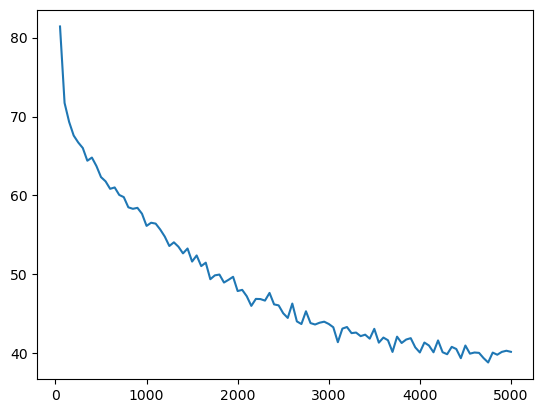

In [15]:
sns.lineplot(x=np.arange(plot_every, n_epochs + 1, plot_every), y=losses)
plt.show()

In [222]:
def sample(model, category, start_letter, max_length=50, k=1):
    model.eval()
    with torch.no_grad():
        h = model.zero_hidden().to(device)
        category_tensor = category_to_tensor(category).to(device)
        input_tensor = input_to_tensor(start_letter).to(device)
        
        # TODO: modify to use beam search
        output_name_ls = [start_letter]
        for i in range(max_length):
            yhat, h = model(category_tensor, input_tensor[0], h)
            topv, topi = yhat.topk(k)
            if topi.numel() > 1:
                topi = topi.squeeze().to("cpu").numpy()
                topv = topv.squeeze().to("cpu").numpy()
            else:
                topi = topi.squeeze(dim=1).to("cpu").numpy()
                topv = topv.squeeze(dim=1).to("cpu").numpy()
            topi = np.random.choice(topi, p=np.exp(topv)/np.sum(np.exp(topv)))
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name_ls.append(letter)
            input_tensor = input_to_tensor(letter)
    return "".join(output_name_ls)


def samples(model, category, start_letters, max_length=50, k=1):
    names = []
    for start_letter in start_letters:
        names.append(sample(model, category, start_letter, max_length=max_length, k=k))
    return names

In [223]:
samples(model, "Irish", "CCC", k=3)

['Carmi', 'Cleirign', 'Cleir']